In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from xgboost import DMatrix
from sklearn.metrics import ndcg_score

In [ ]:
df = pd.read_csv('all_data.csv')
df

,race_id,date,place,track,length,direction,weather,condition,rank,horse_num,horse_id,jockey_id,popularity,sex,age,trainer,attr_course,attr_length,attr_leg,attr_growth,attr_condition,f_res_1st,f_res_2nd,f_res_3rd,f_res_lose,mf_res_1st,mf_res_2nd,mf_res_3rd,mf_res_lose,weight,jockey_weight,jockey_age
0,202002020410,2020-07-12,1,0,2600,1,1,0,1,6,2017101695,1015,10,0,3,22112,58,1,116,58,116,0,0,0,0,12,1,0,1,454,50,42
1,202002020410,2020-07-12,1,0,2600,1,1,0,2,8,2015100243,1091,4,0,5,857,116,1,58,1,87,7,12,8,23,5,1,2,0,468,47,34
2,202002020410,2020-07-12,1,0,2600,1,1,0,3,11,2016101207,5203,5,0,4,4193,58,58,58,58,58,6,6,1,9,0,0,0,0,474,50,46
3,202002020410,2020-07-12,1,0,2600,1,1,0,4,13,2016104887,1032,2,0,4,921,58,58,58,58,58,5,4,3,7,1,0,0,0,488,45,40
4,202002020410,2020-07-12,1,0,2600,1,1,0,5,9,2016103294,1127,3,0,4,4391,58,58,58,58,58,5,4,3,7,0,0,0,0,462,47,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44171,201508010111,2015-01-04,7,0,1600,1,0,0,14,10,2006103340,1126,16,0,8,4098,109,83,15,42,66,5,2,1,0,0,0,0,0,500,47,24
44172,201508010111,2015-01-04,7,0,1600,1,0,0,15,17,2011100693,1018,8,1,3,4169,106,106,106,82,83,0,0,0,0,0,0,0,0,454,51,37
44173,201508010111,2015-01-04,7,0,1600,1,0,0,16,14,2008106438,1144,17,0,6,4377,110,111,74,73,58,4,0,0,0,1,0,0,2,526,46,22
44174,201508010111,2015-01-04,7,0,1600,1,0,0,17,18,2011104231,894,9,0,3,4436,116,96,1,29,87,7,0,1,0,4,0,0,0,460,52,47


In [ ]:
df_train = df[df['date'] < '2019-07-01']
df_test = df[df['date'] >= '2019-07-01']

print(df_train.shape, df_test.shape)

(35806, 52) (8370, 52)


In [ ]:
train_query = df_train.groupby('race_id')['date'].count().tolist()
test_query = df_test.groupby('race_id')['date'].count().tolist()

In [ ]:
cols = ['place', 'track', 'length', 'direction', 'weather', 'condition', 'horse_num', 'jockey_id', 'popularity', 'sex', 'age',
        'trainer', 'attr_course', 'attr_length', 'attr_leg', 'attr_growth', 'attr_condition', 'f_res_1st', 'f_res_2nd', 'f_res_3rd', 'f_res_lose',
        'mf_res_1st', 'mf_res_2nd', 'mf_res_3rd', 'mf_res_lose', 'weight', 'jockey_weight', 'jockey_age', 'total_count', 'total_score', 'total_top3',
        'place_count', 'place_win_score', 'place_top3', 'length_count', 'length_win_score', 'length_top3', 'direction_count', 'direction_win_score',
        'direction_top3', 'quarter', 'year', 'month_cos', 'month_sin', 'weather*condition']

In [ ]:
# LightGBM

params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'lambdarank_truncation_level': 10,
    'ndcg_eval_at': [5, 10, 20],
    'n_estimators': 10000,
    'boosting_type': 'gbdt',
    'random_state': 0,
}


lgtrain = lgb.Dataset(df_train[cols], df_train['rank'], group=train_query)
lgvalid = lgb.Dataset(df_test[cols], df_test['rank'], group=test_query)
lgb_clf = lgb.train(
    params,
    lgtrain,
    valid_sets=[lgvalid],
    early_stopping_rounds=2,
    verbose_eval=5
)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2 rounds.
[5]	valid_0's ndcg@5: 0.536549	valid_0's ndcg@10: 0.638821	valid_0's ndcg@20: 0.673236
Early stopping, best iteration is:
[4]	valid_0's ndcg@5: 0.540363	valid_0's ndcg@10: 0.643675	valid_0's ndcg@20: 0.678402


In [ ]:
pred = lgb_clf.predict(df_test[cols], num_iteration=lgb_clf.best_iteration)
pred_df = pd.DataFrame({
    "query_id": np.repeat(np.arange(len(test_query)), test_query),
    "pred": pred,
    "true": df_test['rank']
})

def get_pred(row):
    temp = pred_df[pred_df['query_id'] == row['query_id']]
    preds = sorted(temp['pred'].values.tolist(), reverse=True)
    return preds.index(row['pred']) + 1
pred_df['pred_rank'] = pred_df.apply(get_pred, axis=1)

pred_df[pred_df['query_id'] == 0]

,query_id,pred,true,pred_rank
0,0,0.022426,1,2
1,0,-0.125369,2,7
2,0,-0.099388,3,6
3,0,-0.125369,4,7
4,0,-0.125369,5,7
5,0,-0.053292,6,4
6,0,-0.075615,7,5
7,0,0.032421,8,1
8,0,-0.026968,9,3
9,0,-0.133931,10,10


In [ ]:
print(pred_df.groupby("query_id").apply(lambda d: ndcg_score([d["true"]], [d["pred"]], k=10)).mean())

0.8529057414889286


In [ ]:
pred = lgb_clf.predict(df_test[cols], num_iteration=lgb_clf.best_iteration)
pred_df_lgb = pd.DataFrame({
    "query_id": np.repeat(np.arange(len(test_query)), test_query),
    "pred": pred,
    "true": df_test['rank']
})

def get_pred(row):
    temp = pred_df_lgb[pred_df_lgb['query_id'] == row['query_id']]
    preds = sorted(temp['pred'].values.tolist(), reverse=True)
    return preds.index(row['pred']) + 1
pred_df_lgb['pred_rank'] = pred_df_lgb.apply(get_pred, axis=1)

pred_df_lgb.head(21)

,query_id,pred,true,pred_rank
0,0,0.022426,1,2
1,0,-0.125369,2,7
2,0,-0.099388,3,6
3,0,-0.125369,4,7
4,0,-0.125369,5,7
5,0,-0.053292,6,4
6,0,-0.075615,7,5
7,0,0.032421,8,1
8,0,-0.026968,9,3
9,0,-0.133931,10,10


In [ ]:
print(pred_df_lgb.groupby("query_id").apply(lambda d: ndcg_score([d["true"]], [d["pred"]], k=10)).mean())

0.8529057414889286


,feature,importance
8,popularity,0.266667
14,attr_leg,0.100000
29,total_score,0.066667
11,trainer,0.055556
38,direction_win_score,0.055556
35,length_win_score,0.055556
6,horse_num,0.044444
7,jockey_id,0.033333
20,f_res_lose,0.022222
25,weight,0.022222


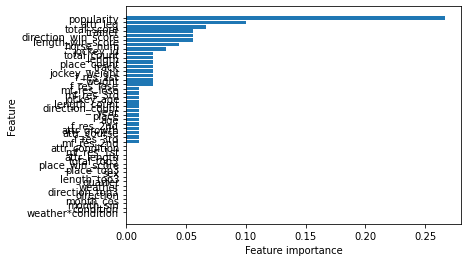

In [ ]:
def plot_feature_importance(df): 
    n_features = len(df) # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_imoprtance_plot = df_plot['importance'].values # 特徴量重要度の取得 
    plt.barh(range(n_features), f_imoprtance_plot, align='center') 
    cols_plot = df_plot['feature'].values # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)  # x軸,y軸の値の設定
    plt.xlabel('Feature importance') # x軸のタイトル
    plt.ylabel('Feature') # y軸のタイトル

f_importance = np.array(lgb_clf.feature_importance()) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化(必要ない場合はコメントアウト)
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

plot_feature_importance(df_importance)

In [ ]:
xgb_params =  {
    'objective': 'rank:pairwise',
    'eta': 0.1,
    'gamma': 0.0001,
    'min_child_weight': 0.1,
    'max_depth': 6
}
xgtrain = DMatrix(df_train[cols], df_train['rank'])
xgtrain.set_group(train_query)
xgvalid = DMatrix(df_test[cols], df_test['rank'])
xgvalid.set_group(test_query)

xgb_clf = xgb.train(
    xgb_params,
    xgtrain,
    num_boost_round=10,
    evals=[(xgvalid, 'validation')]
)

[0]	validation-map:1
[1]	validation-map:1
[2]	validation-map:1
[3]	validation-map:1
[4]	validation-map:1
[5]	validation-map:1
[6]	validation-map:1
[7]	validation-map:1
[8]	validation-map:1
[9]	validation-map:1


In [ ]:
pred = xgb_clf.predict(DMatrix(df_test[cols]))
pred_df_xgb = pd.DataFrame({
    "query_id": np.repeat(np.arange(len(test_query)), test_query),
    "pred": pred,
    "true": df_test['rank']
})

def get_pred(row):
    temp = pred_df_xgb[pred_df_xgb['query_id'] == row['query_id']]
    preds = sorted(temp['pred'].values.tolist(), reverse=True)
    return preds.index(row['pred']) + 1
pred_df_xgb['pred_rank'] = pred_df_xgb.apply(get_pred, axis=1)

pred_df_xgb[pred_df_xgb['query_id'] == 0]

,query_id,pred,true,pred_rank
0,0,0.752527,1,2
1,0,0.304796,2,7
2,0,0.357920,3,6
3,0,0.225591,4,9
4,0,0.268203,5,8
5,0,0.517370,6,4
6,0,0.506253,7,5
7,0,0.765919,8,1
8,0,0.591697,9,3
9,0,-0.024327,10,10


In [ ]:
print(pred_df.groupby("query_id").apply(lambda d: ndcg_score([d["true"]], [d["pred"]], k=10)).mean())

0.8559108205633071
